# E-commerce Clickstream Data Analysis

In [213]:
# https://www.kaggle.com/datasets/waqi786/e-commerce-clickstream-and-transaction-dataset/data

In [214]:
# https://www.kaggle.com/code/moshengfan/e-commerce-data-analytics
# https://www.kaggle.com/code/syaugialkaf/2-e-commerce-c-t-feature-engineering
# https://www.kaggle.com/code/syaugialkaf/1-e-commerce-c-t-data-exploration

In [215]:
import pandas as pd 
import numpy as np
import datetime 
from datetime import datetime 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules


from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from pandas.tseries.holiday import USFederalHolidayCalendar
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# import warnings
# warnings.filterwarnings('ignore')


In [216]:
df = pd.read_csv('./ecommerce_clickstream_transactions.csv')

df_data = df.copy()
df.head()

,UserID,SessionID,Timestamp,EventType,ProductID,Amount,Outcome
0,1,1,2024-07-07 18:00:26.959902,page_view,NaN,NaN,NaN
1,1,1,2024-03-05 22:01:00.072000,page_view,NaN,NaN,NaN
2,1,1,2024-03-23 22:08:10.568453,product_view,prod_8199,NaN,NaN
3,1,1,2024-03-12 00:32:05.495638,add_to_cart,prod_4112,NaN,NaN
4,1,1,2024-02-25 22:43:01.318876,add_to_cart,prod_3354,NaN,NaN


In [217]:
print(f"Clickstream data has {df.shape[0]} rows and {df.shape[1]} columns.")

Clickstream data has 74817 rows and 7 columns.


In [218]:
# check data types
print(df.dtypes)

UserID         int64
SessionID      int64
Timestamp     object
EventType     object
ProductID     object
Amount       float64
Outcome       object
dtype: object


In [219]:
# check summary info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74817 entries, 0 to 74816
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   UserID     74817 non-null  int64  
 1   SessionID  74817 non-null  int64  
 2   Timestamp  74817 non-null  object 
 3   EventType  74817 non-null  object 
 4   ProductID  32113 non-null  object 
 5   Amount     10682 non-null  float64
 6   Outcome    10682 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 4.0+ MB


In [220]:
#missing values

print('missing value sum:')
print(df.isnull().sum())

print('\n\nmissing value mean:')
round(df.isna().mean(), 3)

missing value sum:
UserID           0
SessionID        0
Timestamp        0
EventType        0
ProductID    42704
Amount       64135
Outcome      64135
dtype: int64


missing value mean:


UserID       0.000
SessionID    0.000
Timestamp    0.000
EventType    0.000
ProductID    0.571
Amount       0.857
Outcome      0.857
dtype: float64

In [221]:
# summary statistics
df.describe(include=np.number)

,UserID,SessionID,Amount
count,74817.000000,74817.000000,10682.000000
mean,500.740741,5.509777,253.189758
std,288.945183,2.869337,143.043974
min,1.000000,1.000000,5.131843
25%,251.000000,3.000000,130.933965
50%,501.000000,6.000000,253.112517
75%,751.000000,8.000000,378.832078
max,1000.000000,10.000000,499.981538


In [222]:
df.duplicated().sum()

0

In [223]:
# Investigate the unique values
def unique_values(df):
    return [print(f'{col}: {pd.unique(df[col])}') for col in df.columns if df[col].nunique() <= 15]


def category_col(df):
    return [col for col in df.columns if df[col].nunique() <= 15]

   
unique_values(df)

SessionID: [ 1  2  3  4  5  6  7  8  9 10]
EventType: ['page_view' 'product_view' 'add_to_cart' 'login' 'click' 'logout'
 'purchase']
Outcome: [nan 'purchase']


[None, None, None]

In [224]:
# Investigate relationship between Eventtype and Product ID
df.groupby('EventType')['ProductID'].count()

EventType
add_to_cart     10735
click               0
login               0
logout              0
page_view           0
product_view    10696
purchase        10682
Name: ProductID, dtype: int64

In [225]:
#check if event types return outcome 'purchase

print(f'When EventType = add_to_cart\n {df[(df["EventType"] == "add_to_cart") & (df["Outcome"] == "purchase")]},\n')

print(f'When EventType = click\n {df[(df["EventType"] == "click") & (df["Outcome"] == "purchase")]},\n')

print(f'When EventType = login\n {df[(df["EventType"] == "login") & (df["Outcome"] == "purchase")]},\n')

print(f'When EventType = logout\n {df[(df["EventType"] == "logout") & (df["Outcome"] == "purchase")]},\n')

print(f'When EventType = page_view\n {df[(df["EventType"] == "page_view") & (df["Outcome"] == "purchase")]},\n')

print(f'When EventType = product_view\n {df[(df["EventType"] == "product_view") & (df["Outcome"] == "purchase")]},\n')
    
print(f'When EventType = purchase:\n there are {len(df[(df["EventType"] == "purchase") & (df["Outcome"] == "purchase")])} purchase actions\n')
    


When EventType = add_to_cart
 Empty DataFrame
Columns: [UserID, SessionID, Timestamp, EventType, ProductID, Amount, Outcome]
Index: [],

When EventType = click
 Empty DataFrame
Columns: [UserID, SessionID, Timestamp, EventType, ProductID, Amount, Outcome]
Index: [],

When EventType = login
 Empty DataFrame
Columns: [UserID, SessionID, Timestamp, EventType, ProductID, Amount, Outcome]
Index: [],

When EventType = logout
 Empty DataFrame
Columns: [UserID, SessionID, Timestamp, EventType, ProductID, Amount, Outcome]
Index: [],

When EventType = page_view
 Empty DataFrame
Columns: [UserID, SessionID, Timestamp, EventType, ProductID, Amount, Outcome]
Index: [],

When EventType = product_view
 Empty DataFrame
Columns: [UserID, SessionID, Timestamp, EventType, ProductID, Amount, Outcome]
Index: [],

When EventType = purchase:
 there are 10682 purchase actions



Only event type 'purchase' results in an outcome 'purchase'. This is confirmed as the number of rows is 10682 which is the number of non missing values in the outcome feature.

There it can be inferred that the missingness observed in feature Outcome is due to missing at random(MAR). In other words the missing values depend on another feature i.e. 'EventType'. From the observations 'Outcome" has a missing value when 'EventType is not 'purchase'.

To handle this missing values in Outcome will be replaced with 'not purchased'.

The same can be said for ProductID with a slight variation -- when EventType click,login, logout, page_view the ProductID is 0(Nan). However, the values are not missing in a sense but technically structurally absent(meaning no product was interacted with during these events). Considering ProdcutID is a categorical feature the Nan values will be replaced with 'no_product'.

In [226]:
# df['Outcome'].value_counts()

In [227]:
# handle missing value for 'Outcome'
df.fillna({'Outcome': 'not_purchased'}, inplace=True)

# handle missing value for 'ProductID'
df.fillna({'ProductID': 'no_product'}, inplace=True)

In [228]:
# Investigate relationship between Event-type and Product ID
df.groupby('EventType')['Amount'].count()

EventType
add_to_cart         0
click               0
login               0
logout              0
page_view           0
product_view        0
purchase        10682
Name: Amount, dtype: int64

Similar to Outcome, Amount is dependent on EventType; thus it is MAR. However this is a continous data type and numerical imputations would only introduce noise.
i.e.: an event type of logout or login does not result in the purchase of an item, hence no amount.
Considering the Outcome feature already provides the context that amount would but as a categorical data type, amount will not be used as a predictor. 




### Manage Feature Datatypes

In [229]:
# cast categorical features to category

# Convert to categorical dtype
def cast_category(df):
    [df[col].astype('category') for col in category_col(df)]
    return df

In [230]:
# cast to category
cast_category(df)

# check changes made
df.select_dtypes(include='category').dtypes

Series([], dtype: object)

In [231]:
# change to datetime
df['Timestamp']= pd.to_datetime(df['Timestamp'])

df['Timestamp'].dtypes

dtype('<M8[ns]')

In [232]:
# extract time, day and month from timestamp
df['Time'] = df['Timestamp'].dt.time

df['Hours'] = df['Timestamp'].dt.hour

df['Minutes'] = df['Timestamp'].dt.minute

df['Seconds'] = df['Timestamp'].dt.second

df['Month'] = df['Timestamp'].dt.month_name()

df['Weekday'] = pd.to_numeric(df['Timestamp'].dt.weekday) + 1

df['DayName'] = df['Timestamp'].dt.day_name()

df['Year'] = df['Timestamp'].dt.year


df.head(10)

,UserID,SessionID,Timestamp,EventType,ProductID,Amount,Outcome,Time,Hours,Minutes,Seconds,Month,Weekday,DayName,Year
0,1,1,2024-07-07 18:00:26.959902,page_view,no_product,NaN,not_purchased,18:00:26.959902,18,0,26,July,7,Sunday,2024
1,1,1,2024-03-05 22:01:00.072000,page_view,no_product,NaN,not_purchased,22:01:00.072000,22,1,0,March,2,Tuesday,2024
2,1,1,2024-03-23 22:08:10.568453,product_view,prod_8199,NaN,not_purchased,22:08:10.568453,22,8,10,March,6,Saturday,2024
3,1,1,2024-03-12 00:32:05.495638,add_to_cart,prod_4112,NaN,not_purchased,00:32:05.495638,0,32,5,March,2,Tuesday,2024
4,1,1,2024-02-25 22:43:01.318876,add_to_cart,prod_3354,NaN,not_purchased,22:43:01.318876,22,43,1,February,7,Sunday,2024
5,1,1,2024-01-01 23:09:51.956825,page_view,no_product,NaN,not_purchased,23:09:51.956825,23,9,51,January,1,Monday,2024
6,1,1,2024-02-01 05:13:26.944169,add_to_cart,prod_4965,NaN,not_purchased,05:13:26.944169,5,13,26,February,4,Thursday,2024
7,1,1,2024-02-14 15:41:53.071258,login,no_product,NaN,not_purchased,15:41:53.071258,15,41,53,February,3,Wednesday,2024
8,1,1,2024-05-20 23:13:38.011189,click,no_product,NaN,not_purchased,23:13:38.011189,23,13,38,May,1,Monday,2024
9,1,2,2024-06-27 16:17:34.523695,page_view,no_product,NaN,not_purchased,16:17:34.523695,16,17,34,June,4,Thursday,2024


## 2. EDA 

1. distribution of features
2. correlation 

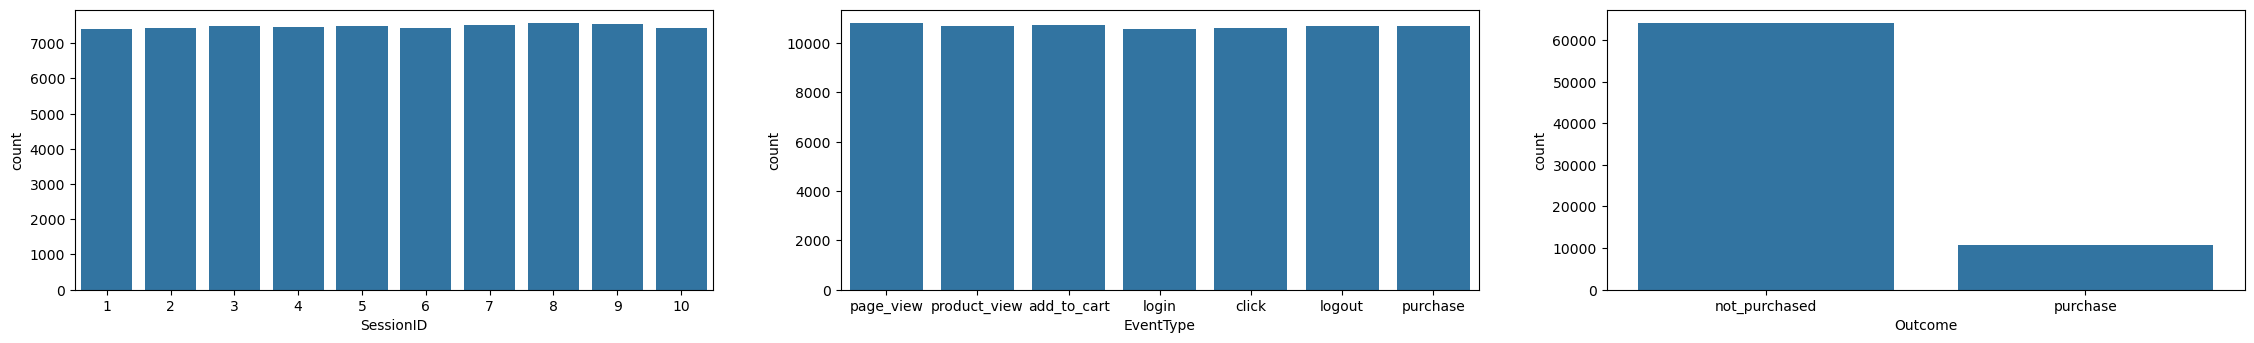

In [233]:
#Count plot

fig = plt.figure(figsize=(28,8))

#establish the subplot canvas add_subplot(row,#/row, order#)
ax0 = fig.add_subplot(2,3,1) 
ax1 = fig.add_subplot(2,3,2)
ax2 = fig.add_subplot(2,3,3)

#plot
sns.countplot(data=df, x='SessionID', ax=ax0)
sns.countplot(data=df, x='EventType', ax=ax1)
sns.countplot(data=df, x= 'Outcome',ax=ax2)

plt.show()

<Axes: xlabel='Outcome', ylabel='count'>

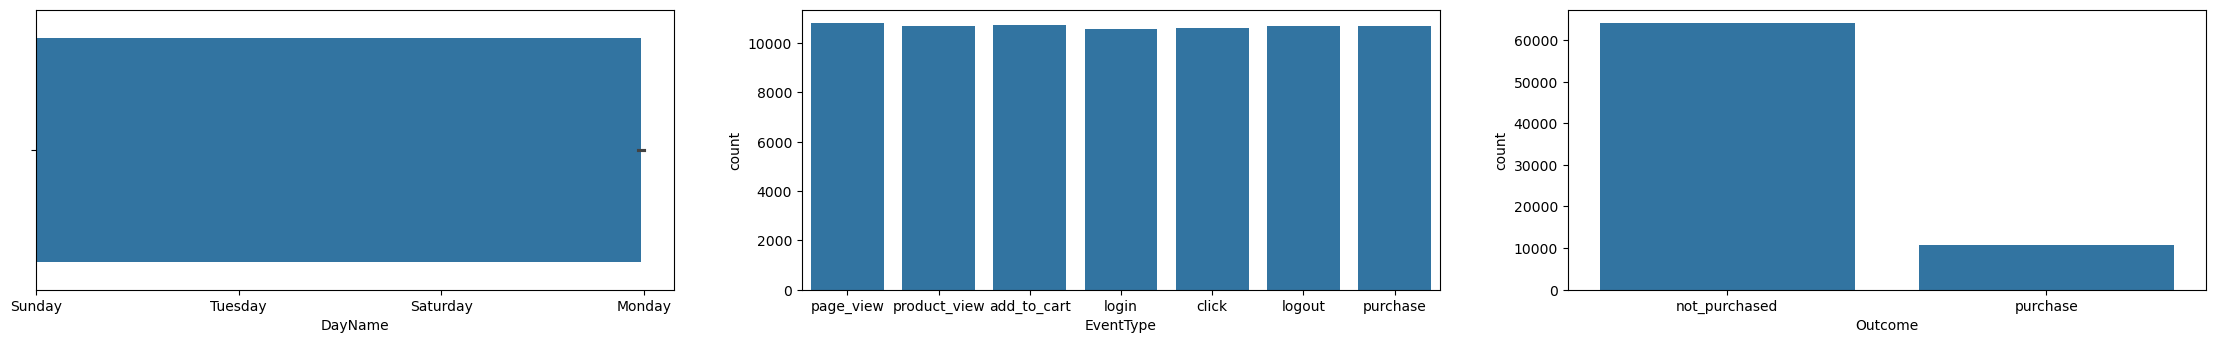

In [234]:
fig = plt.figure(figsize=(28,8))

#establish the subplot canvas add_subplot(row,#/row, order#)
ax0 = fig.add_subplot(2,3,1) 
ax1 = fig.add_subplot(2,3,2)
ax2 = fig.add_subplot(2,3,3)

#plot
sns.barplot(data=df, x='DayName', ax= ax0)
sns.countplot(data=df, x='EventType', ax=ax1)
sns.countplot(data=df, x= 'Outcome',ax=ax2)


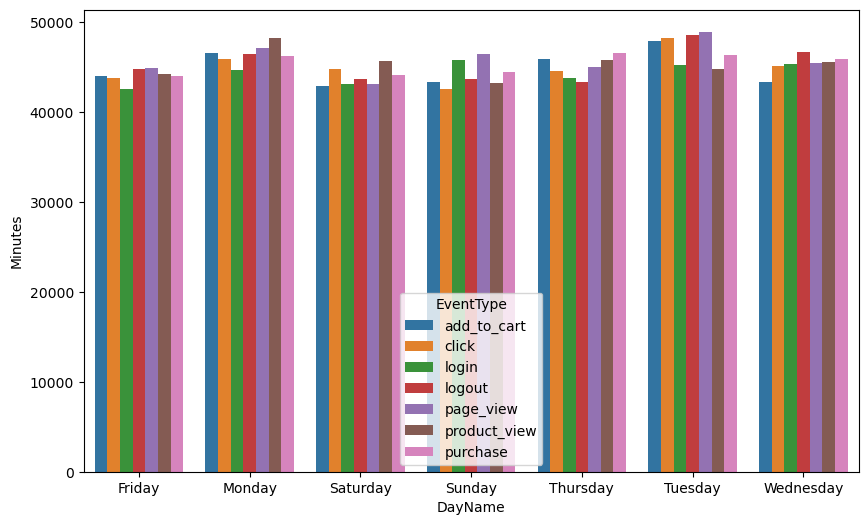

In [235]:
ussage_patterns = df.groupby(['DayName','EventType'])['Minutes'].sum().reset_index()

plt.figure(figsize=(10,6))
sns.barplot(x='DayName', y='Minutes', hue='EventType', data=ussage_patterns)
plt.show()

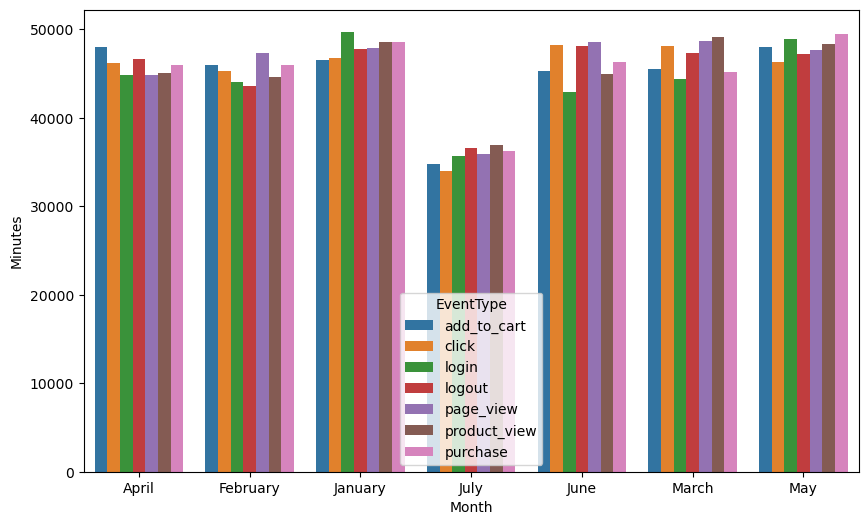

In [236]:
ussage_patterns_m=df.groupby(['Month','EventType'])['Minutes'].sum().reset_index()

plt.figure(figsize=(10,6))
sns.barplot(x='Month', y='Minutes', hue='EventType', data=ussage_patterns_m)
plt.show()

In [237]:
# pd.set_option("display.max_rows", None)
df.groupby(['UserID','SessionID','EventType'])['Minutes'].sum().head()

UserID  SessionID  EventType   
1       1          add_to_cart     88
                   click           13
                   login           41
                   page_view       10
                   product_view     8
Name: Minutes, dtype: int32

In [238]:
# check number unique values for Session ID
print(f'Number of unique data points :{df["SessionID"].nunique()}')

print('value count of unique data points\n')

print(df['SessionID'].value_counts())


Number of unique data points :10
value count of unique data points

SessionID
8     7580
9     7548
7     7532
3     7498
5     7481
4     7461
2     7435
6     7431
10    7431
1     7420
Name: count, dtype: int64


## Feature Engineering

In [239]:
data = df.sort_values(by=['UserID', 'SessionID', 'Timestamp'])

data.head()

,UserID,SessionID,Timestamp,EventType,ProductID,Amount,Outcome,Time,Hours,Minutes,Seconds,Month,Weekday,DayName,Year
5,1,1,2024-01-01 23:09:51.956825,page_view,no_product,NaN,not_purchased,23:09:51.956825,23,9,51,January,1,Monday,2024
6,1,1,2024-02-01 05:13:26.944169,add_to_cart,prod_4965,NaN,not_purchased,05:13:26.944169,5,13,26,February,4,Thursday,2024
7,1,1,2024-02-14 15:41:53.071258,login,no_product,NaN,not_purchased,15:41:53.071258,15,41,53,February,3,Wednesday,2024
4,1,1,2024-02-25 22:43:01.318876,add_to_cart,prod_3354,NaN,not_purchased,22:43:01.318876,22,43,1,February,7,Sunday,2024
1,1,1,2024-03-05 22:01:00.072000,page_view,no_product,NaN,not_purchased,22:01:00.072000,22,1,0,March,2,Tuesday,2024


In [240]:
# Create a column to identify the order of events in each session
data['EventOrder'] = data.groupby(['UserID', 'SessionID']).cumcount() + 1

data.head()

,UserID,SessionID,Timestamp,EventType,ProductID,Amount,Outcome,Time,Hours,Minutes,Seconds,Month,Weekday,DayName,Year,EventOrder
5,1,1,2024-01-01 23:09:51.956825,page_view,no_product,NaN,not_purchased,23:09:51.956825,23,9,51,January,1,Monday,2024,1
6,1,1,2024-02-01 05:13:26.944169,add_to_cart,prod_4965,NaN,not_purchased,05:13:26.944169,5,13,26,February,4,Thursday,2024,2
7,1,1,2024-02-14 15:41:53.071258,login,no_product,NaN,not_purchased,15:41:53.071258,15,41,53,February,3,Wednesday,2024,3
4,1,1,2024-02-25 22:43:01.318876,add_to_cart,prod_3354,NaN,not_purchased,22:43:01.318876,22,43,1,February,7,Sunday,2024,4
1,1,1,2024-03-05 22:01:00.072000,page_view,no_product,NaN,not_purchased,22:01:00.072000,22,1,0,March,2,Tuesday,2024,5


In [241]:
# Aggregate event paths per user per session
user_paths = data.groupby(['UserID', 'SessionID'])['EventType'].apply(lambda x: ' -> '.join(x)).reset_index()
user_paths.head()

,UserID,SessionID,EventType
0,1,1,page_view -> add_to_cart -> login -> add_to_ca...
1,1,2,page_view -> page_view -> logout -> product_vi...
2,1,3,page_view -> login -> add_to_cart -> click -> ...
3,1,4,add_to_cart -> add_to_cart -> login -> page_vi...
4,1,5,logout -> purchase -> purchase -> product_view...


In [242]:
user_paths.tail()

,UserID,SessionID,EventType
9995,1000,6,page_view -> purchase -> page_view -> click ->...
9996,1000,7,add_to_cart -> product_view -> page_view -> pu...
9997,1000,8,logout -> logout -> purchase -> add_to_cart ->...
9998,1000,9,logout -> purchase -> add_to_cart -> logout ->...
9999,1000,10,product_view -> login -> logout -> logout -> p...


In [243]:
# Count the frequency of occurrence of each path
path_counts = user_paths['EventType'].value_counts().reset_index()
path_counts.columns = ['Path', 'Frequency']

# View the most common paths
path_counts.head()

,Path,Frequency
0,click -> logout -> purchase -> purchase -> login,3
1,login -> page_view -> click -> add_to_cart -> ...,3
2,login -> login -> logout -> purchase -> page_view,3
3,product_view -> page_view -> purchase -> produ...,3
4,purchase -> page_view -> page_view -> add_to_c...,2


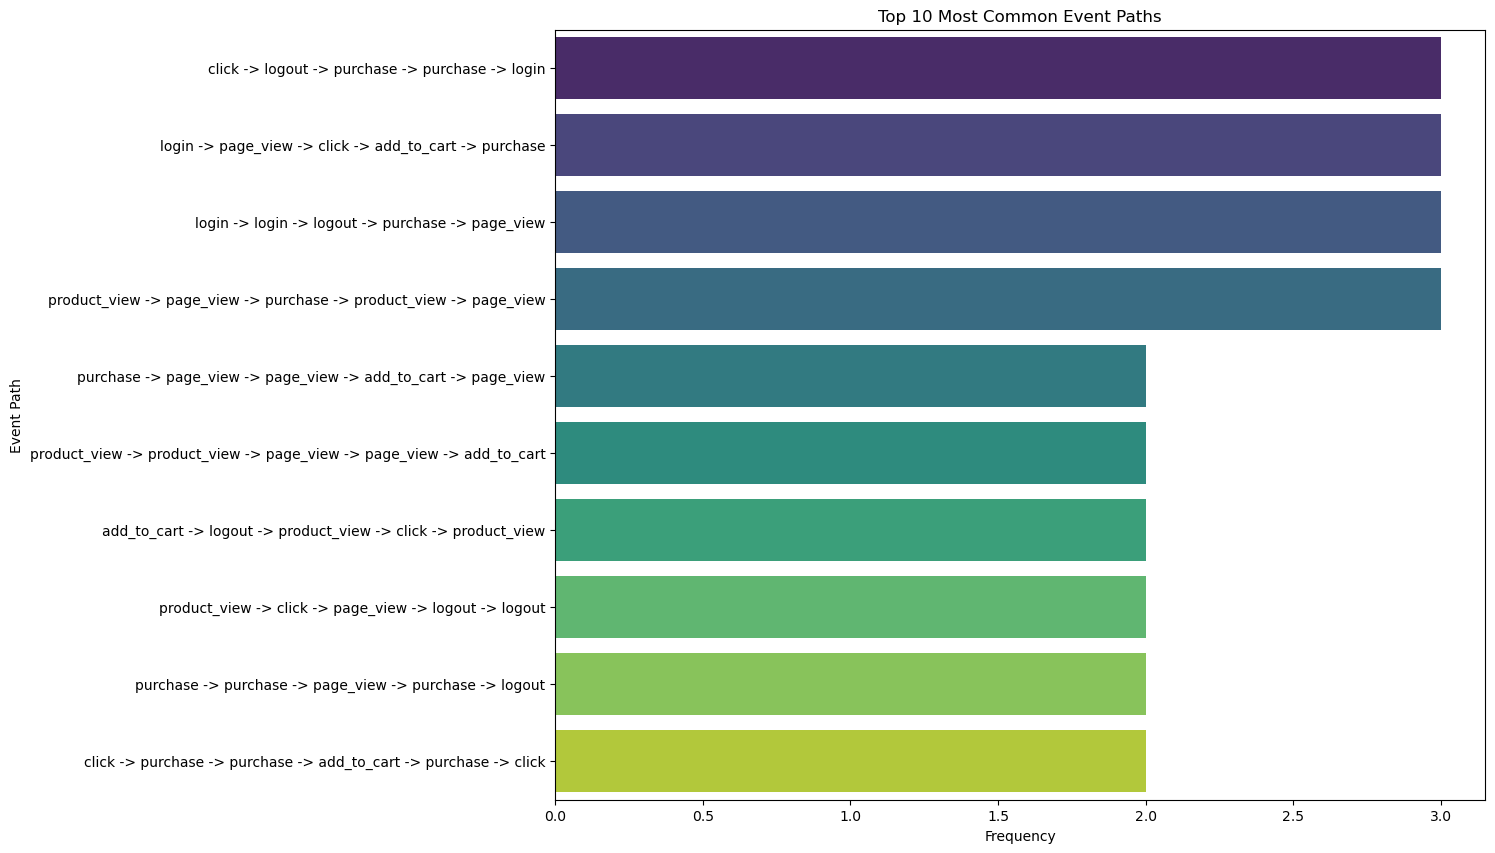

In [244]:
# Select the top 10 most common paths for visualization
top_paths = path_counts.head(10)
plt.figure(figsize=(12, 10))
sns.barplot(x='Frequency', y='Path', data=top_paths, palette='viridis', hue='Path', legend=False)
plt.title('Top 10 Most Common Event Paths')
plt.xlabel('Frequency')
plt.ylabel('Event Path')
plt.show()

In [245]:
# Add a column to indicate whether a purchase event occurred
data['IsPurchase'] = data['EventType'] == 'purchase'

# Aggregate the path of each user in each session and whether they purchased
user_paths_with_purchase = data.groupby(['UserID', 'SessionID']).agg({'EventType': lambda x: ' -> '.join(x), 'IsPurchase': 'max'}).reset_index()

# Count the frequency of each path and the frequency of conversion to purchase
path_purchase_counts = user_paths_with_purchase.groupby('EventType').agg({'IsPurchase': ['sum', 'count']}).reset_index()
path_purchase_counts.columns = ['Path', 'PurchaseCount', 'TotalCount']

# Calculating Conversion Rate
path_purchase_counts['ConversionRate'] = path_purchase_counts['PurchaseCount'] / path_purchase_counts['TotalCount']

# View Path Conversion Rate
# print()
path_purchase_counts.sort_values(by='ConversionRate', ascending=False).head()

,Path,PurchaseCount,TotalCount,ConversionRate
0,add_to_cart -> add_to_cart -> add_to_cart -> a...,1,1,1.0
6297,page_view -> login -> purchase -> purchase -> ...,1,1,1.0
6365,page_view -> logout -> login -> page_view -> l...,1,1,1.0
6364,page_view -> logout -> login -> logout -> purc...,1,1,1.0
6363,page_view -> logout -> login -> logout -> prod...,1,1,1.0


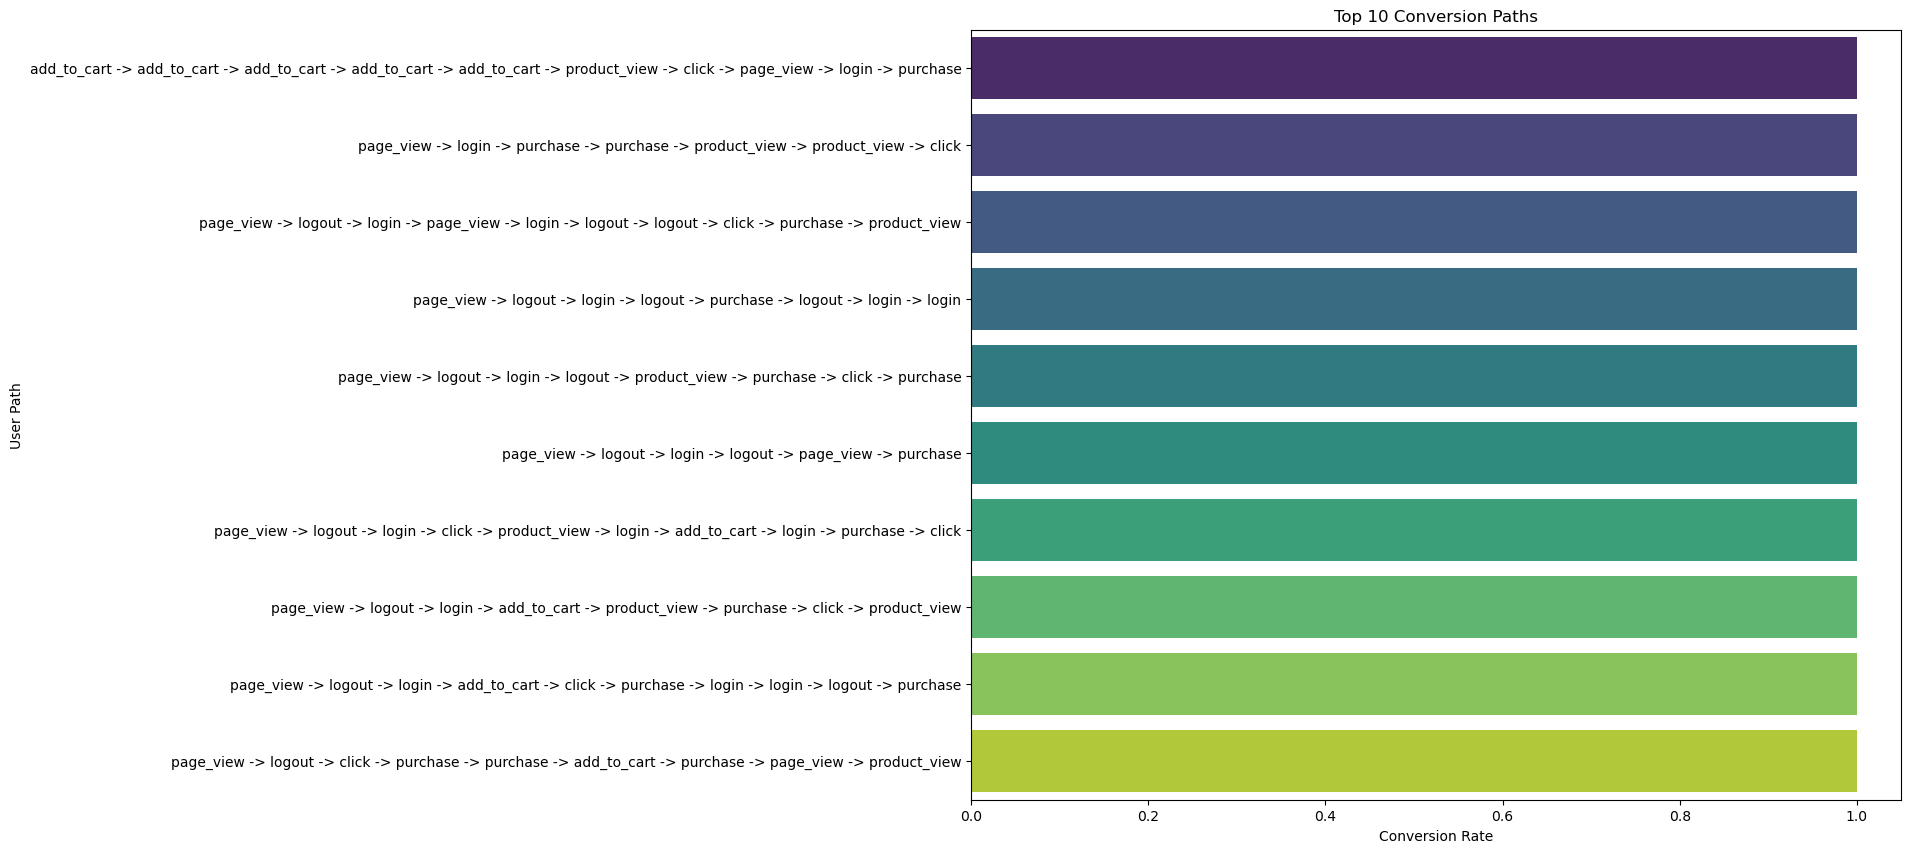

In [246]:
# Select the top 10 paths with the highest conversion rates for visualization
top_conversion_paths = path_purchase_counts.sort_values(by='ConversionRate', ascending=False).head(10)

plt.figure(figsize=(12, 10))
sns.barplot(y='Path', x='ConversionRate', palette='viridis', hue='Path', data=top_conversion_paths, legend=False)
plt.title('Top 10 Conversion Paths')
plt.xlabel('Conversion Rate')
plt.ylabel('User Path')
plt.show()

2. Transaction sequence analysis: Studying user behavior sequences to find out whether specific behaviors (such as browsing a specific product) are more likely to lead to purchases

In [247]:
# Generate event sequences by grouping by user and session
sequences = data.groupby(['UserID', 'SessionID'])['EventType'].apply(list).reset_index()

sequences.head()

,UserID,SessionID,EventType
0,1,1,"[page_view, add_to_cart, login, add_to_cart, p..."
1,1,2,"[page_view, page_view, logout, product_view, c..."
2,1,3,"[page_view, login, add_to_cart, click, add_to_..."
3,1,4,"[add_to_cart, add_to_cart, login, page_view, a..."
4,1,5,"[logout, purchase, purchase, product_view, log..."


In [248]:
# %pip install mlxtend

In [249]:
# Convert data into a format suitable for sequential pattern mining
te = TransactionEncoder()
te_ary = te.fit(sequences['EventType']).transform(sequences['EventType'])
df = pd.DataFrame(te_ary, columns=te.columns_)

# Use apriori algorithm to find frequent itemsets
frequent_itemsets = apriori(df, min_support=0.1, use_colnames=True)

# Generate rules using association rule algorithms
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)

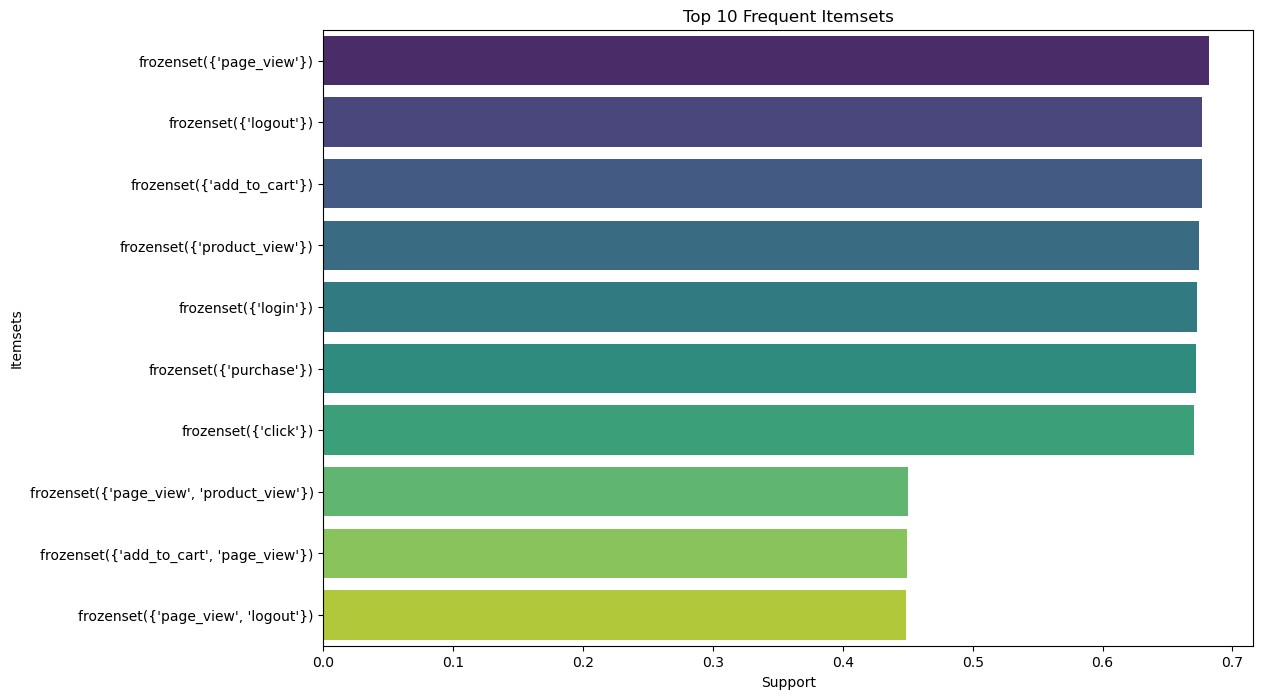

In [250]:
# Plot the top 10 frequent itemsets
top_itemsets = frequent_itemsets.sort_values(by='support', ascending=False).head(10)

# top_itemsets['itemsets'].astype(str)
plt.figure(figsize=(12, 8))
sns.barplot(y='itemsets', x='support', palette='viridis', data=top_itemsets, legend=False, hue='itemsets')
plt.title('Top 10 Frequent Itemsets')
plt.xlabel('Support')
plt.ylabel('Itemsets')
plt.show()

3. User behavior pattern recognition
Use clustering algorithms to identify user behavior patterns and find out the typical behaviors of high-value users and lost users.

In [251]:
# Use pivot_table to calculate the counts for each behavior separately
user_features = data.pivot_table(index='UserID', columns='EventType', aggfunc='size', fill_value=0).reset_index()

# Make sure the column names are set correctly
user_features.columns.name = None  # Remove column name index
user_features.rename(columns={'page_view': 'PageViews', 'click': 'Clicks', 'purchase': 'Purchases'}, inplace=True)

user_features.head()

,UserID,add_to_cart,Clicks,login,logout,PageViews,product_view,Purchases
0,1,23,5,11,6,15,14,8
1,2,18,10,9,9,10,4,13
2,3,11,10,5,13,9,10,6
3,4,14,9,13,12,17,9,9
4,5,13,15,8,13,14,14,7


In [252]:
# Standardizing Data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(user_features[['PageViews', 'Clicks', 'Purchases']])

# 2. Cluster analysis
# Use KMeans clustering algorithm
kmeans = KMeans(n_clusters=4, random_state=42)
user_features['Cluster'] = kmeans.fit_predict(scaled_features)

# Calculate the silhouette coefficient to evaluate the clustering effect
silhouette_avg = silhouette_score(scaled_features, user_features['Cluster'])
print(f'Silhouette Score: {silhouette_avg:.2f}')

Silhouette Score: 0.24


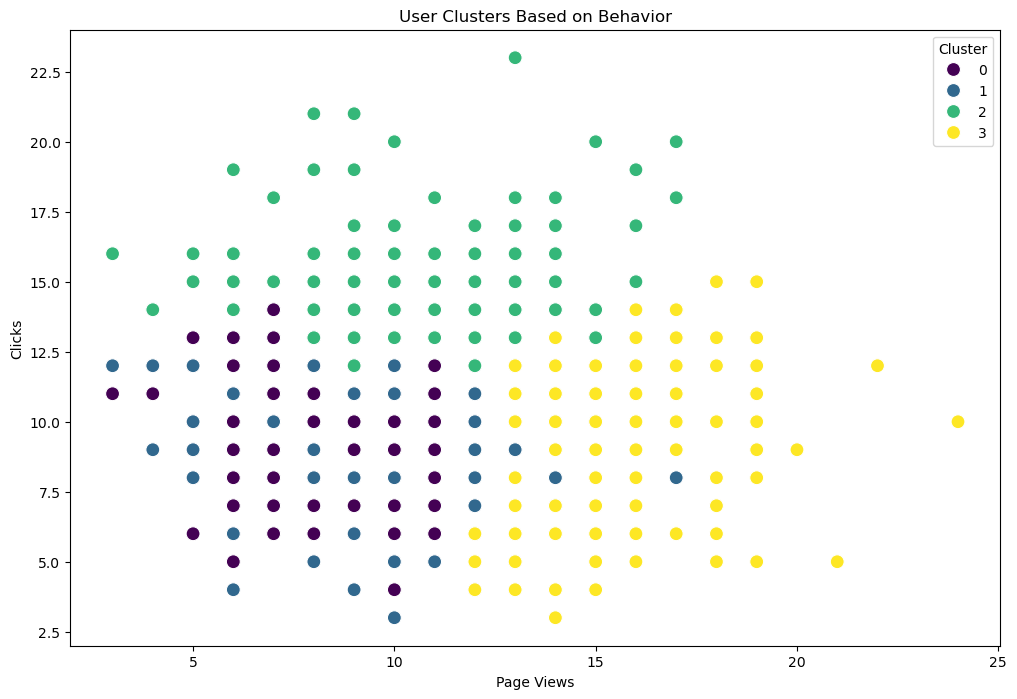

In [253]:
# Visualize the results
plt.figure(figsize=(12, 8))
sns.scatterplot(data=user_features, x='PageViews', y='Clicks', hue='Cluster', palette='viridis', s=100)
plt.title('User Clusters Based on Behavior')
plt.xlabel('Page Views')
plt.ylabel('Clicks')
plt.legend(title='Cluster')
plt.show()

In [254]:
# 5. Analysis and visualization
# Calculate the average characteristics of each market segment
cluster_summary = user_features.groupby('Cluster').agg({
    'PageViews': 'mean',
    'Clicks': 'mean',
    'Purchases': 'mean',
    'UserID': 'count'  # Number of users in each cluster
}).reset_index()

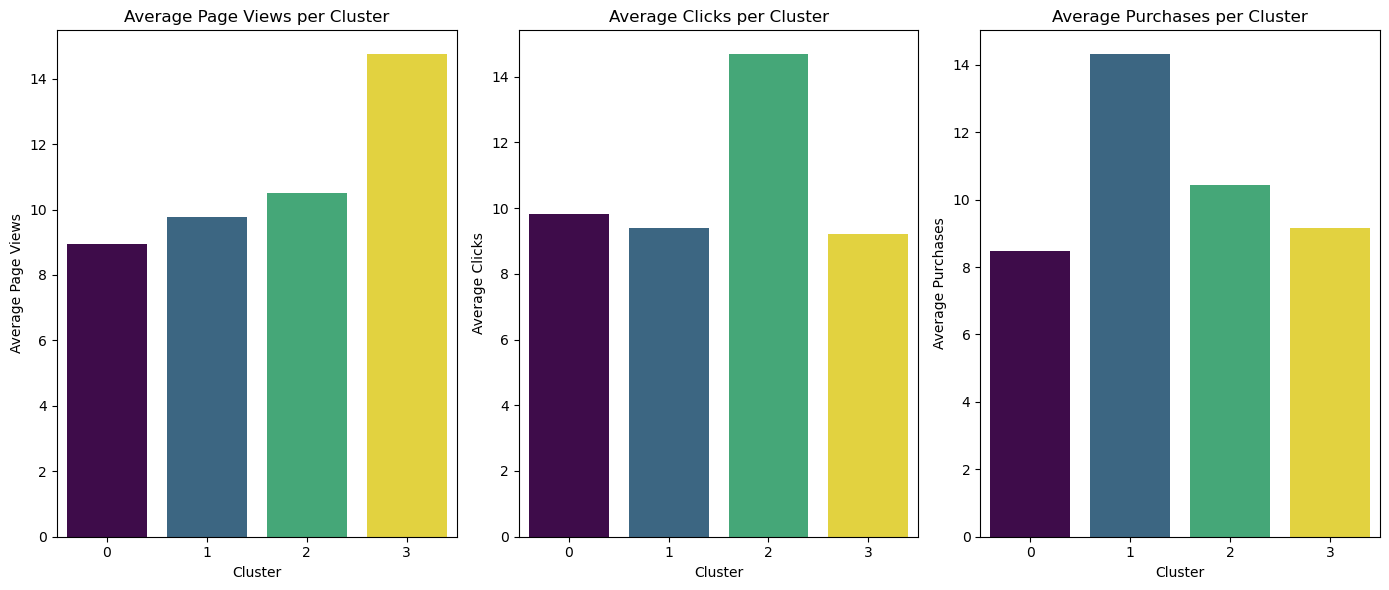

Cluster Summary:


,Cluster,PageViews,Clicks,Purchases,UserID
0,0,8.945848,9.826715,8.462094,277
1,1,9.781362,9.397849,14.308244,279
2,2,10.500000,14.672727,10.422727,220
3,3,14.741071,9.196429,9.165179,224


In [255]:
# Visualize the characteristics of each market segment
plt.figure(figsize=(14, 6))

plt.subplot(1, 3, 1)
sns.barplot(data=cluster_summary, x='Cluster', y='PageViews', palette='viridis', legend=False, hue='Cluster')
plt.title('Average Page Views per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Page Views')

plt.subplot(1, 3, 2)
sns.barplot(data=cluster_summary, x='Cluster', y='Clicks', palette='viridis', legend=False, hue='Cluster')
plt.title('Average Clicks per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Clicks')

plt.subplot(1, 3, 3)
sns.barplot(data=cluster_summary, x='Cluster', y='Purchases', palette='viridis', legend=False, hue='Cluster')
plt.title('Average Purchases per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Purchases')

plt.tight_layout()
plt.show()

# Output the number of users in each market segment
print("Cluster Summary:")
cluster_summary

4. Time series analysis
Study user activities in different time periods to find out the peak hours of user activity and purchases

In [256]:
data['Hour']= data['Hours']
data['DayOfWeek']= data['DayName']

In [257]:
# 2. Calculate peak times for user activity
activity_by_hour = data.groupby('Hour').size().reset_index(name='ActivityCount')
activity_by_day = data.groupby('DayOfWeek').size().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']).reset_index(name='ActivityCount')

In [258]:
# 3. Calculate peak times for purchasing activity
purchase_data = data[data['EventType'] == 'purchase']
purchase_by_hour = purchase_data.groupby('Hour').size().reset_index(name='PurchaseCount')
purchase_by_day = purchase_data.groupby('DayOfWeek').size().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']).reset_index(name='PurchaseCount')

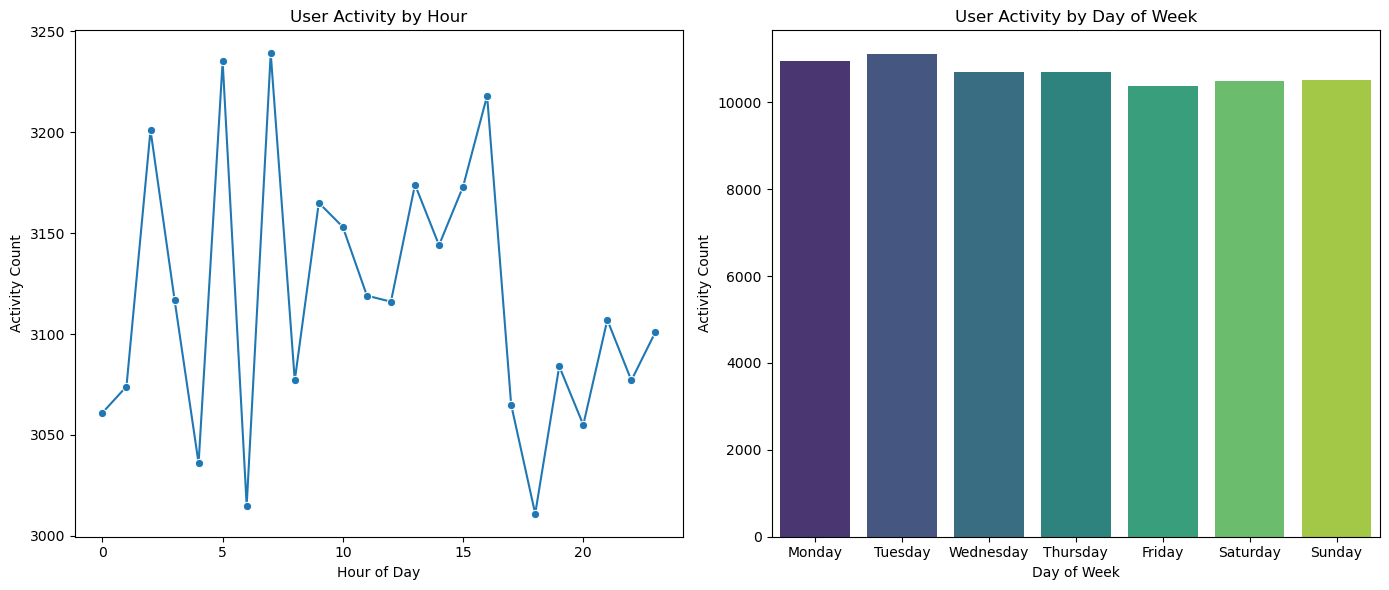

In [259]:
# 4. Visualize user activity
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.lineplot(data=activity_by_hour, x='Hour', y='ActivityCount', marker='o')
plt.title('User Activity by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Activity Count')

plt.subplot(1, 2, 2)
sns.barplot(data=activity_by_day, x='DayOfWeek', y='ActivityCount', palette='viridis', legend=False, hue='DayOfWeek')
plt.title('User Activity by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Activity Count')

plt.tight_layout()
plt.show()

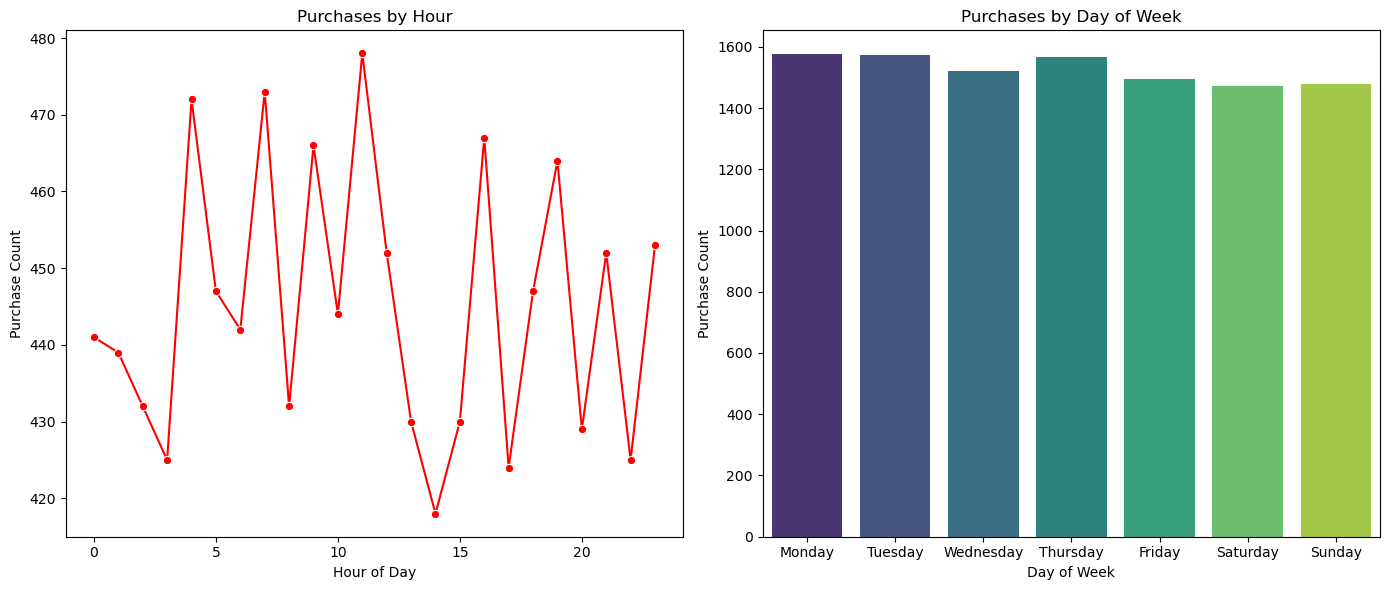

In [260]:
# 5. Visualize purchasing activity
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.lineplot(data=purchase_by_hour, x='Hour', y='PurchaseCount', marker='o', color='r')
plt.title('Purchases by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Purchase Count')

plt.subplot(1, 2, 2)
sns.barplot(data=purchase_by_day, x='DayOfWeek', y='PurchaseCount', palette='viridis', legend=False, hue='DayOfWeek')
plt.title('Purchases by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Purchase Count')

plt.tight_layout()
plt.show()


5. Product Analysis:
Identify best-selling and slow-selling products by analyzing product browsing and purchase data, and adjust inventory and marketing strategies.

In [261]:
# 2. Calculate product views and purchases
product_views = data[data['EventType'] == 'product_view'].groupby('ProductID').size().reset_index(name='ViewCount')
product_purchases = data[data['EventType'] == 'purchase'].groupby('ProductID').size().reset_index(name='PurchaseCount')

# Merge data
product_data = pd.merge(product_views, product_purchases, on='ProductID', how='left').fillna(0)
product_data['PurchaseCount'] = product_data['PurchaseCount'].astype(int)  # 确保购买量为整数

# 3. Identify best-selling and slow-moving products
top_selling_products = product_data.sort_values(by='PurchaseCount', ascending=False).head(10)
bottom_selling_products = product_data.sort_values(by='PurchaseCount').head(10)

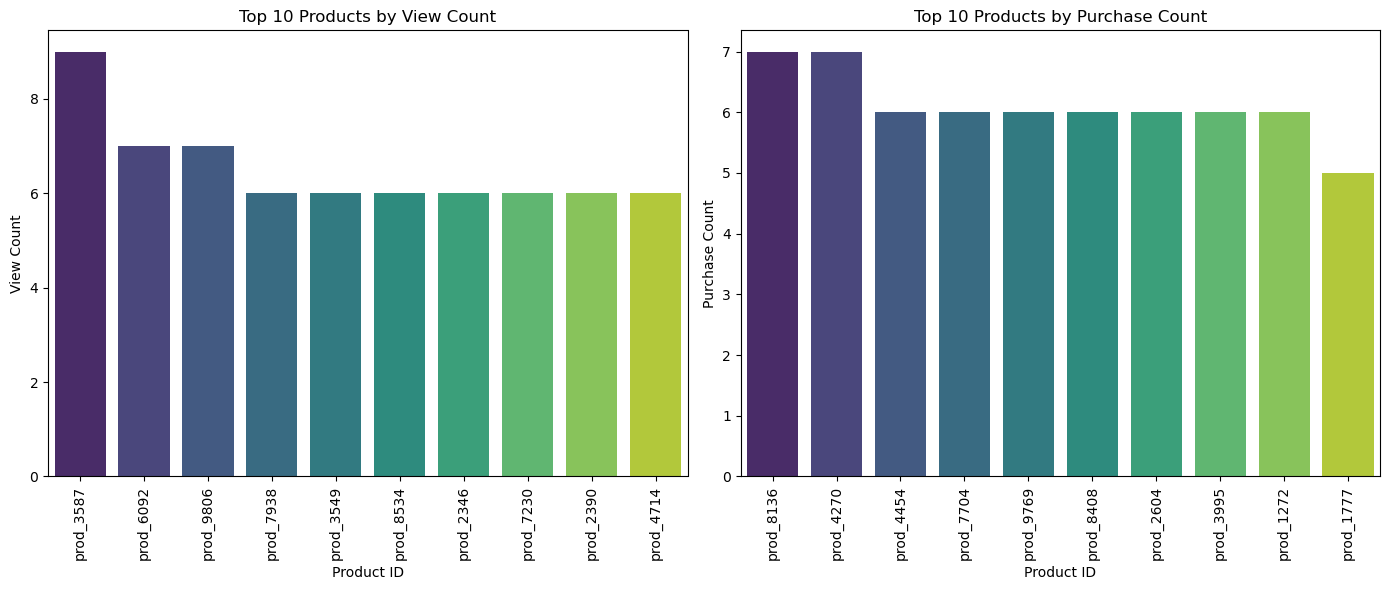

In [262]:
# 4. Visualize product data
plt.figure(figsize=(14, 6))

# Comparison of views and purchases
plt.subplot(1, 2, 1)
sns.barplot(data=product_data.sort_values(by='ViewCount', ascending=False).head(10), x='ProductID', y='ViewCount', palette='viridis', legend=False, hue='ProductID')
plt.title('Top 10 Products by View Count')
plt.xlabel('Product ID')
plt.ylabel('View Count')
plt.xticks(rotation=90)

plt.subplot(1, 2, 2)
sns.barplot(data=product_data.sort_values(by='PurchaseCount', ascending=False).head(10), x='ProductID', y='PurchaseCount', palette='viridis', legend=False, hue='ProductID')
plt.title('Top 10 Products by Purchase Count')
plt.xlabel('Product ID')
plt.ylabel('Purchase Count')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

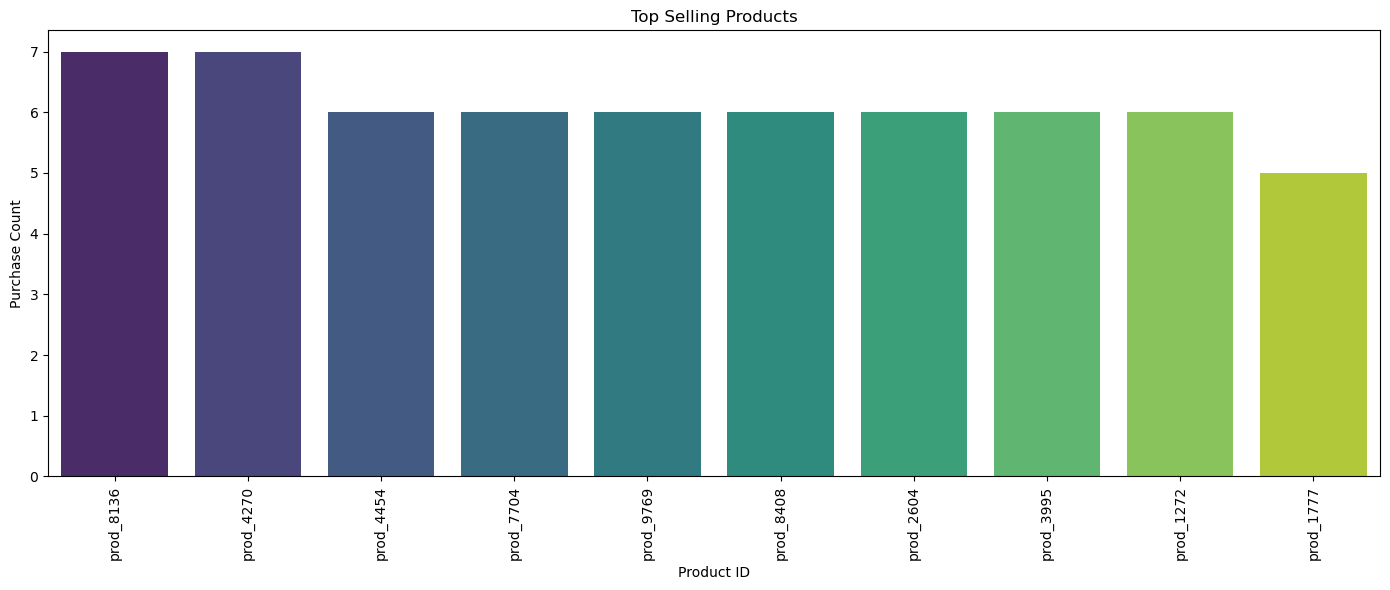

In [263]:
# Histogram of best-selling products
plt.figure(figsize=(14, 6))

# Best Sellers

sns.barplot(data=top_selling_products, x='ProductID', y='PurchaseCount', palette='viridis', legend=False, hue='ProductID')
plt.title('Top Selling Products')
plt.xlabel('Product ID')
plt.ylabel('Purchase Count')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

In [277]:
#  Calculate the sales quantile
quantile_75 = product_data['PurchaseCount'].quantile(0.75)

# Filter products with the bottom 25% sales
bottom_25_products = product_data[product_data['PurchaseCount'] <= quantile_75]

# Output the names of these products
print("Products in the bottom 25% of sales:")
print(bottom_25_products[['ProductID', 'PurchaseCount']].head(10))

Products in the bottom 25% of sales:
   ProductID  PurchaseCount
0  prod_1001              1
1  prod_1002              0
2  prod_1004              0
3  prod_1005              0
4  prod_1006              1
5  prod_1007              2
6  prod_1008              0
7  prod_1009              0
8  prod_1010              1
9  prod_1012              0


In [265]:
class TrafficDataPreprocessor:
    def __init__(self, df: pd.DataFrame):
        self.df = df.copy()
        self.cleaned_data = None
        self.holidays = self._generate_holidays()

    def _generate_holidays(self):
        cal = USFederalHolidayCalendar()
        return cal.holidays(start=self.df['Timestamp'].min(), end=self.df['Timestamp'].max())

    def preprocess(self):
        self.df['Timestamp'] = pd.to_datetime(self.df['Timestamp'])
        self.df.set_index('Timestamp', inplace=True)
        return self.df

    def resample_traffic(self, freq='h'):
        """
        Resample the traffic data to hourly or daily counts.
        """
        grouped = self.df.groupby([pd.Grouper(freq=freq), 'EventType']).size().unstack(fill_value=0)
        grouped['Total'] = grouped.sum(axis=1)
        return grouped

    def generate_features(self, df):
        df = df.copy()
        df['Hour'] = df.index.hour
        df['DayOfWeek'] = df.index.dayofweek
        df['IsWeekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
        df['IsHoliday'] = df.index.normalize().isin(self.holidays).astype(int)
        df['Date'] = df.index
        return df


In [266]:
class TimeSeriesForecaster:
    def __init__(self, time_series: pd.Series):
        self.series = time_series
        self.model = None

    def train_sarima(self, order=(1,1,1), seasonal_order=(1,1,1,24)):
        self.model = SARIMAX(
            self.series,
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(disp=False)
        return self.model

    def forecast(self, steps=24):
        pred = self.model.get_forecast(steps=steps)
        forecast = pred.predicted_mean
        conf_int = pred.conf_int()
        return forecast, conf_int

    def plot_forecast(self, steps=24):
        forecast, conf_int = self.forecast(steps)
        plt.figure(figsize=(14, 6))
        plt.plot(self.series[-100:], label='Historical')
        plt.plot(forecast, label='Forecast')
        plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
        plt.title('SARIMA Forecast')
        plt.legend()
        plt.tight_layout()
        plt.show()


In [267]:
class MLTrafficPredictor:
    def __init__(self, model='xgboost'):
        if model == 'xgboost':
            self.model = XGBRegressor(objective='reg:squarederror', n_estimators=100)
        else:
            self.model = RandomForestRegressor(n_estimators=100)

    def prepare_ml_data(self, df, target_col='Total'):
        df = df.dropna()
        X = df[['Hour', 'DayOfWeek', 'IsWeekend', 'IsHoliday']]
        y = df[target_col]
        return train_test_split(X, y, test_size=0.2, random_state=42)

    def train(self, X_train, y_train):
        self.model.fit(X_train, y_train)
    
    @staticmethod
    def regression_metrics(y_true, y_pred):
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-5))) * 100  # small epsilon for 0 values
        print(f'RMSE: {rmse:.2f}')
        print(f'MAE: {mae:.2f}')
        print(f'R² Score: {r2:.3f}')
        print(f'MAPE: {mape:.2f}%')
        return {"RMSE": rmse, "MAE": mae, "R2": r2, "MAPE": mape}

    def evaluate(self, X_test, y_test):
        preds = self.model.predict(X_test)
        return self.regression_metrics(y_test, preds)

    def predict(self, X_future):
        return self.model.predict(X_future)
    
  

In [268]:
# %pip install prophet

In [269]:
from prophet import Prophet

class ProphetForecaster:
    def __init__(self, df):
        self.model = Prophet(holidays=None, daily_seasonality=True)
        self.df = df.reset_index()[['Timestamp', 'Total']].rename(columns={'Timestamp': 'ds', 'Total': 'y'})
    
    def add_holidays(self, holiday_df):
        self.model = Prophet(holidays=holiday_df, daily_seasonality=True)
    
    def train(self):
        self.model.fit(self.df)
    
    def forecast(self, periods=72, freq='h'):
        future = self.model.make_future_dataframe(periods=periods, freq=freq)
        forecast = self.model.predict(future)
        return forecast

    def plot(self, forecast):
        self.model.plot(forecast)
        plt.title("Prophet Forecast")
        plt.show()
        
        self.model.plot_components(forecast)
        plt.show()


In [270]:
df_data = data.copy()

In [271]:
# Load data
# df = pd.read_csv('your_clickstream_data.csv')  # or use your original df

# Preprocessing
preprocessor = TrafficDataPreprocessor(df_data)
df_cleaned = preprocessor.preprocess()

# Resample to hourly
hourly_traffic = preprocessor.resample_traffic(freq='h')
hourly_features = preprocessor.generate_features(hourly_traffic)

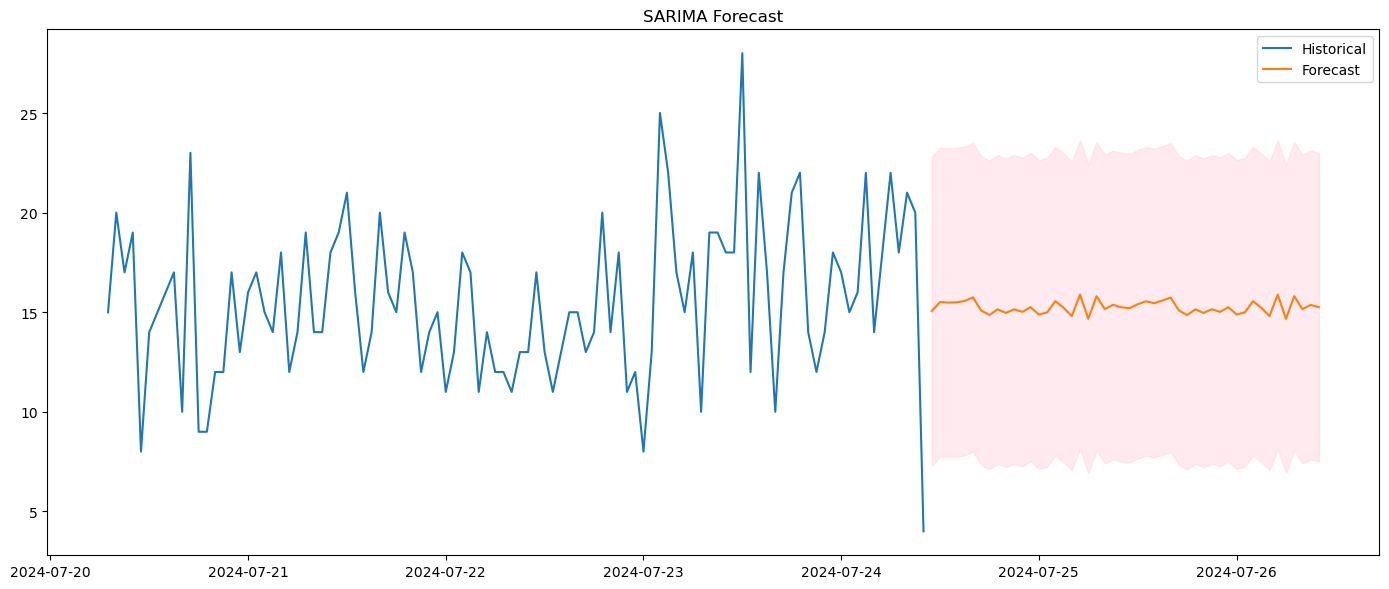

RMSE: 4.07
MAE: 3.27
R² Score: -0.059
MAPE: 23.61%


{'RMSE': 4.070773510660879,
 'MAE': 3.2667138690040227,
 'R2': -0.058652400970458984,
 'MAPE': 23.606755062917475}

In [272]:
# ---------------- SARIMA Forecasting ----------------
sarima_forecaster = TimeSeriesForecaster(hourly_traffic['Total'])
sarima_forecaster.train_sarima(order=(2,1,2), seasonal_order=(1,1,1,24))
sarima_forecaster.plot_forecast(steps=48)  # next 48 hours

# ---------------- ML Forecasting ----------------
ml_predictor = MLTrafficPredictor(model='xgboost')
X_train, X_test, y_train, y_test = ml_predictor.prepare_ml_data(hourly_features)
ml_predictor.train(X_train, y_train)
ml_predictor.evaluate(X_test, y_test)


In [273]:
# ---------------- ML Forecasting ----------------
ml_predictor = MLTrafficPredictor(model='randoomforest')
X_train, X_test, y_train, y_test = ml_predictor.prepare_ml_data(hourly_features)
ml_predictor.train(X_train, y_train)
ml_predictor.evaluate(X_test, y_test)

RMSE: 4.06
MAE: 3.25
R² Score: -0.052
MAPE: 23.53%


{'RMSE': 4.057232045981769,
 'MAE': 3.254974714098823,
 'R2': -0.05162098193636333,
 'MAPE': 23.52554768101562}

14:59:40 - cmdstanpy - INFO - Chain [1] start processing


14:59:40 - cmdstanpy - INFO - Chain [1] done processing


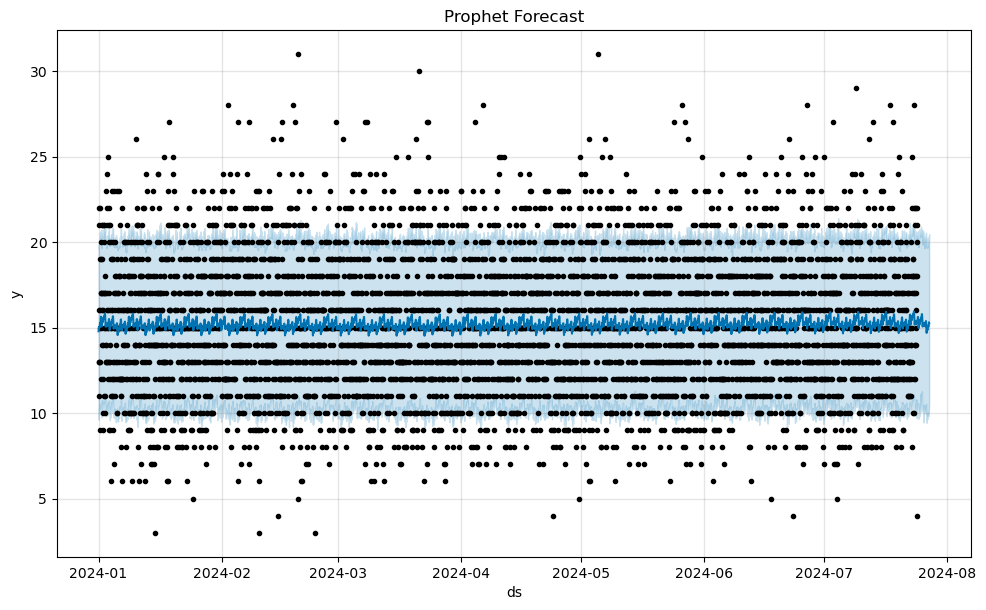

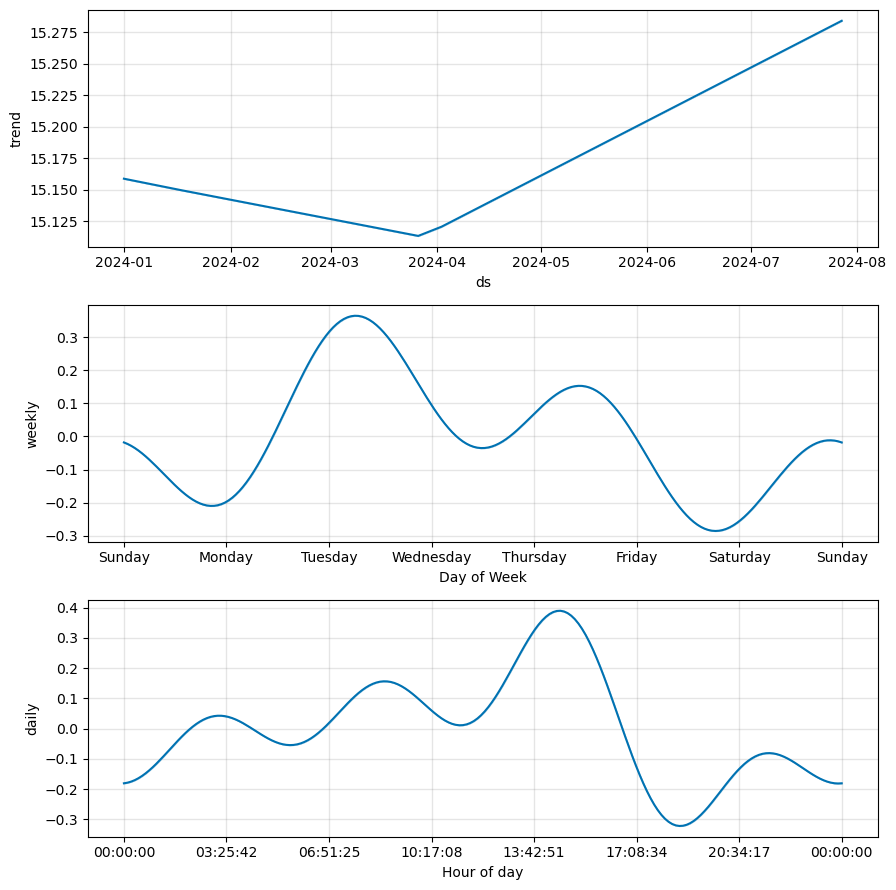

In [274]:
prophet_forecaster = ProphetForecaster(hourly_traffic)
prophet_forecaster.train()
forecast = prophet_forecaster.forecast(periods=72)  # 3 days
prophet_forecaster.plot(forecast)

In [275]:
# results = {
#     # "SARIMA": sarima_forecaster.evaluate(),
#     "XGBoost": ml_predictor.evaluate(X_test, y_test),
#     "Prophet": prophet_evaluation  # if you add a metric
# }

In [276]:
# # Example mock metrics from SARIMA, XGBoost, and Prophet
# model_metrics = {
#     "SARIMA": {"RMSE": 120.5, "MAE": 80.2, "R2": 0.78, "MAPE": 12.3},
#     "XGBoost": {"RMSE": 100.3, "MAE": 65.4, "R2": 0.85, "MAPE": 10.1},
#     "Prophet": {"RMSE": 110.7, "MAE": 70.8, "R2": 0.82, "MAPE": 11.5}
# }

# # Convert to DataFrame
# metrics_df = pd.DataFrame(model_metrics).T

# # Plot
# fig, ax = plt.subplots(figsize=(10, 6))
# metrics_df.plot(kind='bar', ax=ax)
# plt.title("Model Comparison: Forecast Accuracy Metrics")
# plt.ylabel("Score")
# plt.xticks(rotation=0)
# plt.grid(axis='y')
# plt.tight_layout()
# plt.show()
